In [1]:
import os, sys
import numpy as np
import json
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
random.seed(42)
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')

In [3]:
na_list = ['A', 'C', 'G', 'T']
aa_list = ['R', 'L', 'S', 'A', 'G', 'P', 'T', 'V', 'N', 'D', 'C', 'Q', 'E', 'H', 'I', 'K', 'M', 'F', 'W', 'Y']
pvals = [0.089]*3 + [0.065]*5 + [0.034]*12
aa_dict = dict(zip(aa_list, pvals))

## Dataset

In [4]:
aptamer_dataset_file = "../data/aptamer_dataset.json"

def construct_dataset():
    with open(aptamer_dataset_file, 'r') as f:
        aptamer_data = json.load(f)
    full_dataset = []
    for aptamer in aptamer_data:
        peptides = aptamer_data[aptamer]
        if aptamer == "CTTTGTAATTGGTTCTGAGTTCCGTTGTGGGAGGAACATG": #took out aptamer control
            continue
        for peptide, _ in peptides:
            peptide = peptide.replace("_", "") #removed empty slots
            if "RRRRRR" in peptide: #took out peptide control
                continue
            if len(aptamer) == 40 and len(peptide) == 8:#making sure right length
                full_dataset.append((aptamer, peptide))
    return list(set(full_dataset)) #removed duplicates

In [5]:
full_dataset = construct_dataset()
n = len(full_dataset)
aptamers = [p[0] for p in full_dataset]
peptides = [p[1] for p in full_dataset]
training_set = full_dataset[:int(0.8*n)]
test_set = full_dataset[int(0.8*n):]

In [6]:
class TrainDataset(torch.utils.data.Dataset):
    def __init__(self, training_set):
        super(TrainDataset, self).__init__() 
        self.training_set = training_set
        
    def __len__(self):
        return len(self.training_set)

    def __getitem__(self, idx):
        aptamer, peptide = self.training_set[idx]
        return aptamer, peptide
    
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, test_set):
        super(TestDataset, self).__init__() 
        self.test_set = test_set
        
    def __len__(self):
        return len(self.test_set)

    def __getitem__(self, idx):
        aptamer, peptide = self.test_set[idx]
        return aptamer, peptide

In [7]:
train_dataset = TrainDataset(training_set)
test_dataset = TestDataset(test_set)
train_loader = torch.utils.data.DataLoader(train_dataset)
test_loader = torch.utils.data.DataLoader(test_dataset)

## One-hot encoding

In [8]:
## Takes a peptide and aptamer sequence and converts to one-hot matrix
def one_hot(sequence_list, seq_type='peptide'):
    if seq_type == 'peptide':
        letters = aa_list
    else:
        letters = na_list
    
    one_hot = np.zeros((len(sequence_list), len(sequence_list[0]), len(letters)))
    
    for j in range(len(sequence_list)):
        sequence = sequence_list[j]
        for i in range(len(sequence)):
            element = sequence[i]
            idx = letters.index(element)
            one_hot[j][i][idx] = 1
    return one_hot

## NN Model

In [9]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.cnn_apt_1 = nn.Conv2d(40, 20, 1)
        self.cnn_apt_2 = nn.Conv2d(20, 10, 1)
        self.cnn_apt_3 = nn.Conv2d(10, 1, 1)
        self.fc_apt_1 = nn.Linear(160, 1)
        
        self.cnn_pep_1 = nn.Conv2d(8, 4, 1)
        self.cnn_pep_2 = nn.Conv2d(4, 3, 1)
        self.fc_pep_1 = nn.Linear(64, 1)
        
        self.pool = nn.MaxPool2d(1, 1)
        self.relu = nn.ReLU()
                
        self.sequential_pep = nn.Sequential(self.cnn_pep_1,
                                            self.relu, 
                                            self.pool, 
                                            self.cnn_pep_2)
        
        self.sequential_apt = nn.Sequential(self.cnn_apt_1, 
                                            self.relu, 
                                            self.pool, 
                                            self.cnn_apt_2, 
                                            self.relu, 
                                            self.pool, 
                                            self.cnn_apt_3)
        
        self.fc1 = nn.Linear(64, 1)
        
    def forward(self, apt, pep):
        apt = self.sequential_apt(apt).cuda()
        pep = self.sequential_pep(pep).cuda()
        
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        
        x = torch.cat((apt, pep), 1)
        x = self.fc1(x)
        x = torch.sigmoid(x)
        return x

In [10]:
model = ConvNet()
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform_(m.weight.data)
        nn.init.zeros_(m.bias.data)
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight.data, nonlinearity='relu')
        nn.init.zeros_(m.bias.data)

model.apply(weights_init)
model.cuda()

ConvNet(
  (cnn_apt_1): Conv2d(40, 20, kernel_size=(1, 1), stride=(1, 1))
  (cnn_apt_2): Conv2d(20, 10, kernel_size=(1, 1), stride=(1, 1))
  (cnn_apt_3): Conv2d(10, 1, kernel_size=(1, 1), stride=(1, 1))
  (fc_apt_1): Linear(in_features=160, out_features=1, bias=True)
  (cnn_pep_1): Conv2d(8, 4, kernel_size=(1, 1), stride=(1, 1))
  (cnn_pep_2): Conv2d(4, 3, kernel_size=(1, 1), stride=(1, 1))
  (fc_pep_1): Linear(in_features=64, out_features=1, bias=True)
  (pool): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (sequential_pep): Sequential(
    (0): Conv2d(8, 4, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(4, 3, kernel_size=(1, 1), stride=(1, 1))
  )
  (sequential_apt): Sequential(
    (0): Conv2d(40, 20, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)

## Sampling

In [11]:
# Sample x from P_X (assume peptides follow NNK)
def get_x():
    x_idx = np.random.choice(20, 7, p=pvals)
    x = "M"
    for i in x_idx:
        x += aa_list[i]
    return x

# Sample y from P_Y (assume apatamers follow uniform)
def get_y():
    y_idx = np.random.randint(0, 4, 40)
    y = ""
    for i in y_idx:
        y += na_list[i]
    return y

# Generate uniformly from S without replacement
def get_xy(k):
    samples = [full_dataset[i] for i in np.random.choice(len(full_dataset), k, replace=False)]
    return samples

# S' contains S with double the size of S (domain for Importance Sampling)
def get_S_prime(k):
    S_prime = full_dataset[:]
    for _ in range(k):
        S_prime.append((get_y(), get_x()))
    return list(set(S_prime))

# Sample from S' without replacement
def get_xy_prime(k):
    samples = [S_prime[i] for i in np.random.choice(len(S_prime), k, replace=False)]
    return samples

# Returns pmf of a peptide
def get_x_pmf(x):
    pmf = 1
    for char in x[1:]: #skips first char "M"
        pmf *= aa_dict[char]
    return pmf

# Returns pmf of an aptamer
def get_y_pmf():
    return 0.25**40

S_prime = get_S_prime(n)

## SGD

In [12]:
def update(type="original"):
    if type == "original":
        xy = get_xy(1)[0]
    else:
        xy = get_xy_prime(1)[0]
    x = one_hot(xy[0], seq_type='aptamer') 
    y = one_hot(xy[1], seq_type='peptide') 
    x = torch.FloatTensor(np.reshape(x, (1, x.shape[0], x.shape[1], x.shape[2])))
    y = torch.FloatTensor(np.reshape(y, (1, y.shape[0], y.shape[1], y.shape[2])))
    x.requires_grad=True
    y.requires_grad=True
    x = x.cuda()
    y = y.cuda()
    out = model(x, y)
    return xy, out

In [13]:
def sgd(t=500, #num of iter
        lamb=1e-5, #hyperparam
        gamma=1e-5): #step size
    
    model.train()
    for a, _ in enumerate(tqdm.tqdm(range(t))):
        
        xy, out = update()
        out.retain_grad()
        model.zero_grad()
        out.backward()
        
        xy_prime, out_prime = update("prime")
        out_prime = out_prime * get_x_pmf(xy_prime[0]) * get_y_pmf() * 2 * n
        out_prime.retain_grad()
        model.zero_grad()
        out_prime.backward()
        
        const = 0 if xy_prime in full_dataset else 1 #indicator
        g = torch.log(out.grad) - lamb*const*out_prime.grad
        g = g.item()
        
        # Update the weights according to SGD
        for param in model.parameters():
            param.data += gamma * g

## Recall

In [14]:
def evaluate():
    correct = 0
    incorrect = 0
    model.eval()
    for _, (aptamer, peptide) in enumerate(tqdm.tqdm(test_loader)):
        pep = one_hot(peptide, seq_type='peptide')
        apt = one_hot(aptamer, seq_type='aptamer')

        pep = torch.FloatTensor(np.reshape(pep, (1, pep.shape[1], pep.shape[2], pep.shape[0]))).cuda()
        apt = torch.FloatTensor(np.reshape(apt, (1, apt.shape[1], apt.shape[2], apt.shape[0]))).cuda()
        
        output = model(apt, pep).cpu().detach().numpy().flatten()
        for i in range(output.shape[0]):
            o = output[i]
            if o > 0.5:
                correct += 1
            else:
                incorrect += 1
        
    return (100* correct/(correct + incorrect))

## Hyperparameter tuning

In [16]:
gammas = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
lambdas = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
results = []

M = np.zeros((len(gammas), len(lambdas)))
for g in range(len(gammas)):
    for l in range(len(lambdas)):
        model = ConvNet()
        model.apply(weights_init)
        model.cuda()
        print("Training...")
        sgd(t=1000, gamma=gammas[g], lamb=lambdas[l])
        print("Evaluating...")
        recall = evaluate()
        M[g][l] += recall
        results.append(recall)
        print("Recall with gamma: "+ str(gammas[g]) + " , lambda: " + str(lambdas[l]) + " recall: ", recall)

  0%|          | 0/1000 [00:00<?, ?it/s]

Training...


  0%|          | 8/118262 [00:00<25:29, 77.34it/s]

Evaluating...


  0%|          | 1/1000 [00:00<02:46,  6.00it/s]

Recall with gamma: 0 , lambda: 0 recall:  100.0
Training...


 82%|████████▏ | 96478/118262 [05:41<01:15, 288.05it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 33%|███▎      | 38632/118262 [03:39<07:46, 170.62it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 81%|████████  | 95444/118262 [09:00<01:56, 196.21it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--Noteb

Evaluating...


 34%|███▍      | 40582/118262 [05:56<13:02, 99.32it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/1000 [00:00<?, ?it/s]

Recall with gamma: 0 , lambda: 3 recall:  16.700208012717525
Training...


  0%|          | 19/118262 [00:00<11:28, 171.80it/s]

Evaluating...


  9%|▉         | 11201/118262 [01:06<09:46, 182.41it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|█████████▉| 117873/118262 [11:13<00:02, 141.94it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 68%|██████▊   | 80237/118262 [07:10<03:42, 170.78it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--Note

Recall with gamma: 1 , lambda: 0 recall:  100.0
Training...


  0%|          | 7/118262 [00:00<34:02, 57.91it/s]

Evaluating...


 36%|███▌      | 42728/118262 [06:24<14:09, 88.92it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/1000 [00:00<?, ?it/s]

Recall with gamma: 1 , lambda: 1 recall:  90.86857993269182
Training...


  0%|          | 10/118262 [00:00<19:57, 98.75it/s]

Evaluating...


  3%|▎         | 3776/118262 [00:21<09:33, 199.56it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/1000 [00:00<?, ?it/s]

Recall with gamma: 1 , lambda: 2 recall:  50.3509157633052
Training...


 24%|██▍       | 242/1000 [00:54<03:11,  3.96it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 95%|█████████▍| 111934/118262 [10:43<00:37, 169.54it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 91%|█████████ | 107292/118262 [09:46<00:31, 353.71it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--Notebook

Recall with gamma: 2 , lambda: 0 recall:  43.423077573523194
Training...


  0%|          | 38/118262 [00:00<05:13, 377.14it/s]

Evaluating...


 14%|█▍        | 16725/118262 [00:55<05:35, 302.82it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/1000 [00:00<?, ?it/s]

Recall with gamma: 2 , lambda: 1 recall:  24.9513791412288
Training...


  0%|          | 23/118262 [00:00<08:46, 224.64it/s]

Evaluating...


 59%|█████▉    | 69653/118262 [03:34<02:43, 296.97it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 88%|████████▊ | 103639/118262 [05:22<00:47, 309.97it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 24/118262 [00:00<08:18, 236.99it/s]

Evaluating...


 68%|██████▊   | 80589/118262 [04:23<02:10, 287.69it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/1000 [00:00<?, ?it/s]

Recall with gamma: 3 , lambda: 2 recall:  73.68808239333006
Training...


 21%|██▏       | 214/1000 [00:40<03:21,  3.90it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 1/1000 [00:00<02:58,  5.59it/s]

Recall with gamma: 3 , lambda: 4 recall:  92.73477532935347
Training...


  0%|          | 29/118262 [00:00<06:51, 287.22it/s]

Evaluating...


 36%|███▋      | 43034/118262 [02:13<03:46, 331.86it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 87%|████████▋ | 102449/118262 [05:22<00:47, 331.56it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 118262/118262 [06:09<00:00, 319.88it/s]

Recall with gamma: 4 , lambda: 4 recall:  35.76465813194433


## Evaluate

In [31]:
# Table of recalls with different params
idx = sorted(range(len(results)), key=lambda k: results[k])
for i in idx:
    g = gammas[i//len(gammas)]
    l = lambdas[i%len(lambdas)]
    print("Gamma: ", "%.5f" % g, "Lambda: ", "%.5f" % l, "Recall: ", "%.2f" % results[i])

Gamma:  0.00010 Lambda:  0.01000 Recall:  14.20
Gamma:  0.10000 Lambda:  0.00010 Recall:  16.70
Gamma:  0.00100 Lambda:  0.00010 Recall:  19.89
Gamma:  0.00100 Lambda:  0.01000 Recall:  24.95
Gamma:  0.00001 Lambda:  0.00100 Recall:  25.45
Gamma:  0.00010 Lambda:  0.10000 Recall:  29.36
Gamma:  0.00001 Lambda:  0.10000 Recall:  32.14
Gamma:  0.00001 Lambda:  0.00001 Recall:  35.76
Gamma:  0.00100 Lambda:  0.10000 Recall:  43.42
Gamma:  0.00010 Lambda:  0.00010 Recall:  44.87
Gamma:  0.10000 Lambda:  0.00100 Recall:  48.91
Gamma:  0.01000 Lambda:  0.00010 Recall:  49.61
Gamma:  0.01000 Lambda:  0.00100 Recall:  50.35
Gamma:  0.10000 Lambda:  0.00001 Recall:  56.65
Gamma:  0.00100 Lambda:  0.00001 Recall:  60.81
Gamma:  0.00001 Lambda:  0.00010 Recall:  62.21
Gamma:  0.00010 Lambda:  0.00100 Recall:  73.69
Gamma:  0.01000 Lambda:  0.00001 Recall:  75.56
Gamma:  0.00001 Lambda:  0.01000 Recall:  83.36
Gamma:  0.01000 Lambda:  0.01000 Recall:  90.87
Gamma:  0.00100 Lambda:  0.00100 Recall:

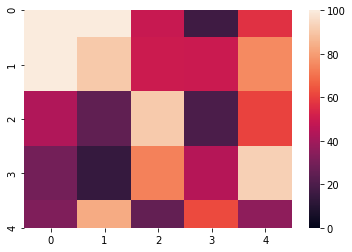

In [29]:
# Heatmap of recalls
mat = sns.heatmap(M, vmin=0, vmax=100)
plt.show()

In [30]:
# AUC --> Ordering graphic
